## Εισαγωγικά

In [ ]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import scipy.stats

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

In [2]:
# Set random seed for reproducibility
import random
import os
SEED = 56
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.utils import check_random_state
check_random_state(SEED)

RandomState(MT19937) at 0x272727D2640

In [3]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## Β. Προεπεξεργασία και Εξερεύνηση Δεδομένων

### 1. Εξερευνητική Ανάλυση Δεδομένων (EDA)

In [4]:
# Load data with pickling enabled
data = np.load(r'C:\\Users\\vasgk\\Desktop\\Μηχανική μάθηση\\Data\\breastmnist_224.npz', allow_pickle=True)

# Inspect the keys in the dataset
print("Keys in the dataset:", data.files)
print("Shape of file contents: (no of contents, dimensions (224x224))")

# Print the shape of each file in the original npz file
for key in data.files:
    print(f"{key}: {data[key].shape}")

Keys in the dataset: ['train_images', 'train_labels', 'val_images', 'val_labels', 'test_images', 'test_labels']
Shape of file contents: (no of contents, dimensions (224x224))
train_images: (546, 224, 224)
train_labels: (546, 1)
val_images: (78, 224, 224)
val_labels: (78, 1)
test_images: (156, 224, 224)
test_labels: (156, 1)


In [5]:
# Convert the data into a DataFrame
# Flatten the images and combine them with labels
train_images_flat = data['train_images'].reshape(len(data['train_images']), -1)  # Flatten 224x224 images
df_train = pd.DataFrame(train_images_flat)
df_train['Label'] = data['train_labels']

val_images_flat = data['val_images'].reshape(len(data['val_images']), -1)
df_val = pd.DataFrame(val_images_flat)
df_val['Label'] = data['val_labels']

# Combine train and validation sets into a new train set
combined_images_flat = np.vstack([train_images_flat, val_images_flat])
combined_labels = np.concatenate([data['train_labels'], data['val_labels']])

df_train_combined = pd.DataFrame(combined_images_flat)
df_train_combined['Label'] = combined_labels

# Flatten the test images and create a DataFrame with labels
test_images_flat = data['test_images'].reshape(len(data['test_images']), -1)
df_test = pd.DataFrame(test_images_flat)
df_test['Label'] = data['test_labels']

# Split the data into features and labels for the rest of the code to be compatible with my group's code 
x_train = df_train_combined.drop(columns=['Label']).values
y_train = df_train_combined['Label'].values.ravel()
x_test = df_test.drop(columns=['Label']).values  
y_test = df_test['Label'].values.ravel()  

### 2. Προεπεξεργασία Δεδομένων

#### α. Χειρισμός ακραίων τιμών: δεν υπάρχουν ελλειπούσες τιμές

#### β. Κανονικοποίηση/Τυποποίηση χαρακτηριστικών: 
Για την κανονικοποίηση/τυποποίηση των χαρακτηριστικών, εφαρμόστηκε η μέθοδος Standard Scaling (Z-score normalization), ώστε κάθε χαρακτηριστικό να έχει μέση τιμή 0 και τυπική απόκλιση 1. Η επιλογή αυτή έγινε επειδή οι αλγόριθμοι PCA, LDA και Logistic Regression είναι ευαίσθητοι στην κλίμακα των χαρακτηριστικών. Η κατανομή των τιμών πριν και μετά την τυποποίηση απεικονίστηκε με ιστογράμματα, ενώ παρατηρήθηκε ότι η τυποποίηση βελτιώνει τη διακριτική ικανότητα και τη σύγκλιση των αλγορίθμων.

In [ ]:

# Standardize features
scaler = StandardScaler()
x_train_std = scaler.fit_transform(combined_images_flat)
x_test_std = scaler.transform(test_images_flat)

### γ. Επιλογή και μετασχηματισμός χαρακτηριστικών:

#### 1. Αφαίρεση χαρακτηριστικών με χαμηλή διακύμανση (Remove low-variance features)
You can use VarianceThreshold from scikit-learn to remove features (pixels) with very low variance, which are unlikely to be useful for classification

In [ ]:

# Remove features with variance below a threshold (e.g., 0.01)
selector = VarianceThreshold(threshold=0.01)
x_train_var = selector.fit_transform(x_train_std)
x_test_var = selector.transform(x_test_std)

print("Original shape:", x_train_std.shape)
print("After variance thresholding:", x_train_var.shape)

Original shape: (624, 50176)
After variance thresholding: (624, 50176)


#### 2. Δημιουργία νέων χαρακτηριστικών (Feature engineering)
For images, common new features include mean, standard deviation, or other statistics per image. Example:

#### Extracting Features

In [8]:
# Add mean and std of pixel values as new features
# Use the same data as used for x_train_var and x_test_var (i.e., standardized data)
train_means = x_train_std.mean(axis=1, keepdims=True)
train_stds = x_train_std.std(axis=1, keepdims=True)
x_train_fe = np.hstack([x_train_var, train_means, train_stds])

test_means = x_test_std.mean(axis=1, keepdims=True)
test_stds = x_test_std.std(axis=1, keepdims=True)
x_test_fe = np.hstack([x_test_var, test_means, test_stds])

In [ ]:
# Train a simple model to compare performance with and without the new features


# Model with only variance-thresholded features
clf1 = LogisticRegression(max_iter=1000, random_state=56)
clf1.fit(x_train_var, y_train)
y_pred1 = clf1.predict(x_test_var)
y_val = data['test_labels']  # This should match x_val_var
acc1 = accuracy_score(y_test, y_pred1)

# Model with mean and std features added
clf2 = LogisticRegression(max_iter=1000, random_state=56)
clf2.fit(x_train_fe, y_train)
y_pred2 = clf2.predict(x_test_fe)
acc2 = accuracy_score(y_test, y_pred2)

# model with all stats

print(f"Accuracy without mean/std: {acc1:.4f}")
print(f"Accuracy with mean/std:    {acc2:.4f}")

Accuracy without mean/std: 0.8141
Accuracy with mean/std:    0.8013


## Γ. Μείωση Διαστάσεων

### 1) LDA

In [10]:
# LDA (Linear Discriminant Analysis) 

# Number of LDA components (at most n_classes - 1)
n_classes = len(np.unique(y_train))
n_components = n_classes - 1

# Fit LDA on training data
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_train_lda = lda.fit_transform(x_train_fe, y_train)
X_test_lda = lda.transform(x_test_fe)

print("LDA reduced train shape:", X_train_lda.shape)
print("LDA reduced test shape:", X_test_lda.shape)

LDA reduced train shape: (624, 1)
LDA reduced test shape: (156, 1)


## Δ. Κλασικοί Αλγόριθμοι Ταξινόμησης

### 1. Logistic Regression

In [16]:
# Logistic regression with LDA features

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

# Train logistic regression on LDA features
LogisticRegression_lda = LogisticRegression(max_iter=1000, random_state=56)
LogisticRegression_lda.fit(X_train_lda, y_train)

# Predict on test set (LDA features)
y_pred_lda = LogisticRegression_lda.predict(X_test_lda)

In [17]:
# Grid search for best hyperparameters in Logistic Regression with LDA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from sklearn.metrics import make_scorer, recall_score


# Define parameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs'],
    'penalty': [None, 'l2'],
    'max_iter': [100,1000,2500,5000],
    
}

# Initialize Logistic Regression (no need to set random_state for grid search)
logreg = LogisticRegression()
# Custom scorer for recall of class 0
recall_0 = make_scorer(recall_score, pos_label=0)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3, 
    n_jobs=-1,
    verbose=2,
    scoring=recall_0
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 320 candidates, totalling 960 fits
Best parameters found: {'C': np.float64(0.0001), 'class_weight': 'balanced', 'max_iter': 100, 'penalty': None, 'solver': 'lbfgs'}
Best cross-validation score: 0.8928571428571428
Test Accuracy: 0.8141025641025641

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68        42
           1       0.90      0.84      0.87       114

    accuracy                           0.81       156
   macro avg       0.76      0.79      0.78       156
weighted avg       0.83      0.81      0.82       156



C:\Users\vasgk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(



Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.67      0.64        42
           1       0.87      0.84      0.86       114

    accuracy                           0.79       156
   macro avg       0.74      0.75      0.75       156
weighted avg       0.80      0.79      0.80       156

Accuracy: 0.7949
Precision (macro): 0.7407
Recall (macro): 0.7544
F1 Score (macro): 0.7468


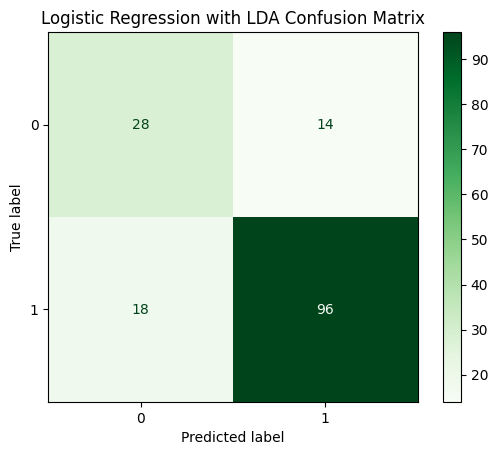

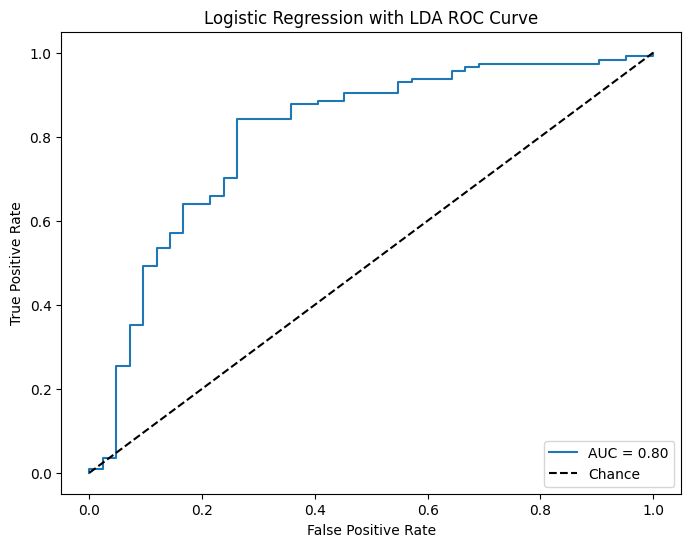

In [18]:
# Final Model

# Train logistic regression on PCA features
LogisticRegression_pca = LogisticRegression(
    C=0.0001,
    penalty='l2',
    class_weight='balanced',
    solver='lbfgs',
    max_iter=100,
    random_state=56
)
LogisticRegression_pca.fit(X_train_lda, y_train)

# Predict on test set (LDA features)
y_pred_lda = LogisticRegression_pca.predict(X_test_lda)

# Assess the model's performance
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,
    recall_score, f1_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def assess_model_performance(clf, X_test, y_test, class_labels=None, title_prefix=""):
    # Predict
    y_pred = clf.predict(X_test)
    if class_labels is None:
        class_labels = np.unique(y_test)

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    # ROC Curve (if possible)
    y_score = None
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)

    if y_score is not None:
        # Binary classification: plot only one ROC curve
        if len(class_labels) == 2:
            # y_score may be 1D (decision_function) or 2D (predict_proba)
            if y_score.ndim == 1:
                fpr, tpr, _ = roc_curve(y_test, y_score)
            else:
                fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{title_prefix} ROC Curve')
            plt.legend(loc="lower right")
            plt.show()
        else:
            # Multiclass case (your original code)
            y_test_bin = label_binarize(y_test, classes=class_labels)
            plt.figure(figsize=(8, 6))
            for i, class_label in enumerate(class_labels):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{title_prefix} ROC Curve - All Classes')

# Assess the model's performance
assess_model_performance(LogisticRegression_pca, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Logistic Regression with LDA")

### 2. Support Vector Machines

In [ ]:
# Grid search for best hyperparameters in SVM with PCA features



# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.0001, 0.001],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
}

# Initialize SVM classifier
svm = SVC()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    scoring=make_scorer(recall_score, pos_label=0)  # Custom scorer for recall of class 0
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}
Best cross-validation score: 1.0
SVM Test Accuracy: 0.4807692307692308

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.93      0.49        42
           1       0.92      0.32      0.47       114

    accuracy                           0.48       156
   macro avg       0.63      0.62      0.48       156
weighted avg       0.76      0.48      0.48       156




Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68        42
           1       0.90      0.84      0.87       114

    accuracy                           0.81       156
   macro avg       0.76      0.79      0.78       156
weighted avg       0.83      0.81      0.82       156

Accuracy: 0.8141
Precision (macro): 0.7649
Recall (macro): 0.7901
F1 Score (macro): 0.7750


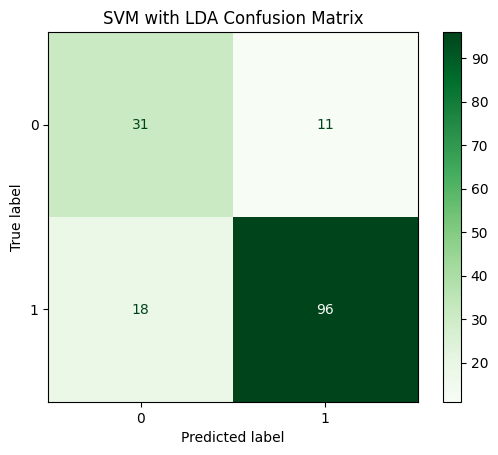

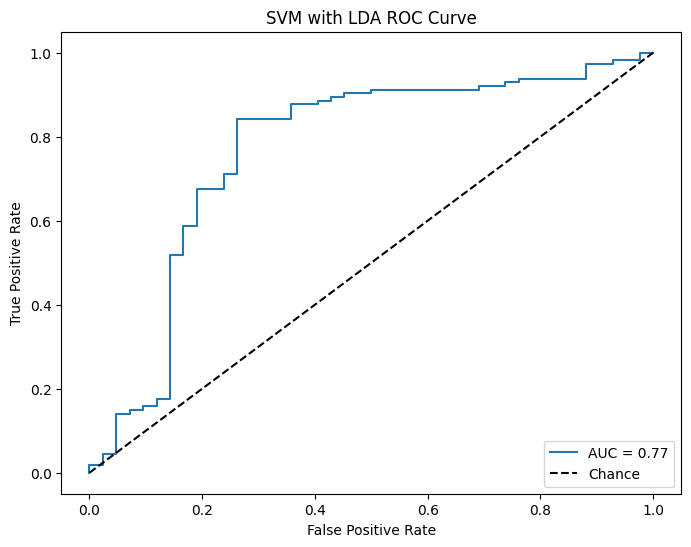

In [21]:
# Classification SVM with PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_lda)

assess_model_performance(svm_clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="SVM with LDA")


### 3. k-Κοντινότεροι Γείτονες (k-NN)

In [ ]:
# Grid search for best hyperparameters in KNN with PCA features



# Define parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    scoring=make_scorer(recall_score, pos_label=0)  # Custom scorer for recall of class 0
)


# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': np.int64(2), 'weights': 'uniform'}
Best cross-validation score: 0.8511904761904763
KNN Test Accuracy: 0.7435897435897436

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.64      0.57        42
           1       0.86      0.78      0.82       114

    accuracy                           0.74       156
   macro avg       0.69      0.71      0.70       156
weighted avg       0.77      0.74      0.75       156




Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.63        42
           1       0.86      0.87      0.86       114

    accuracy                           0.80       156
   macro avg       0.75      0.74      0.75       156
weighted avg       0.80      0.80      0.80       156

Accuracy: 0.8013
Precision (macro): 0.7475
Recall (macro): 0.7437
F1 Score (macro): 0.7456


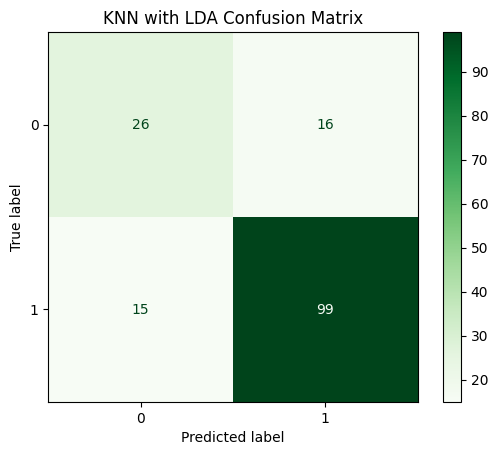

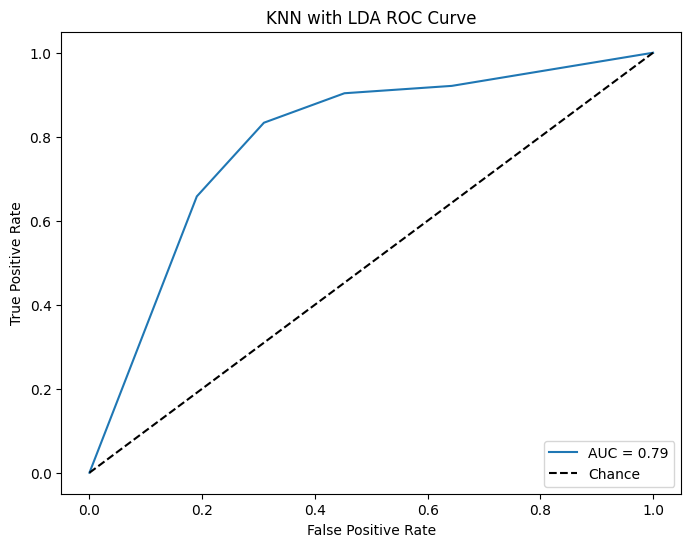

In [23]:
# KNN classification with PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_lda, y_train)

# Predict on test set
y_pred = knn.predict(X_test_lda)

# Evaluate
assess_model_performance(knn, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="KNN with LDA")

### 4. Naive Bayes

In [ ]:
# Grid search for best hyperparameters in Naive Bayes with PCA features


# Define parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0, -50, 10)  # Typical range for var_smoothing
}

# Initialize GaussianNB classifier
nb = GaussianNB()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    scoring=make_scorer(recall_score, pos_label=0)  # Custom scorer for recall of class 0
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'var_smoothing': np.float64(2.782559402207126e-06)}
Best cross-validation score: 0.8154761904761904
Naive Bayes Test Accuracy: 0.8076923076923077

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.62        42
           1       0.86      0.89      0.87       114

    accuracy                           0.81       156
   macro avg       0.76      0.74      0.75       156
weighted avg       0.80      0.81      0.80       156




Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.60      0.62        42
           1       0.86      0.89      0.87       114

    accuracy                           0.81       156
   macro avg       0.76      0.74      0.75       156
weighted avg       0.80      0.81      0.80       156

Accuracy: 0.8077
Precision (macro): 0.7569
Recall (macro): 0.7406
F1 Score (macro): 0.7478


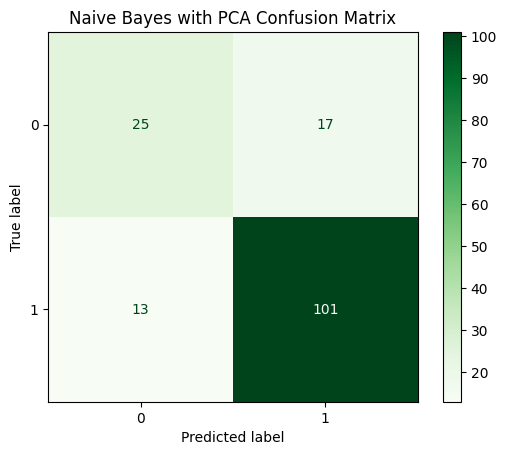

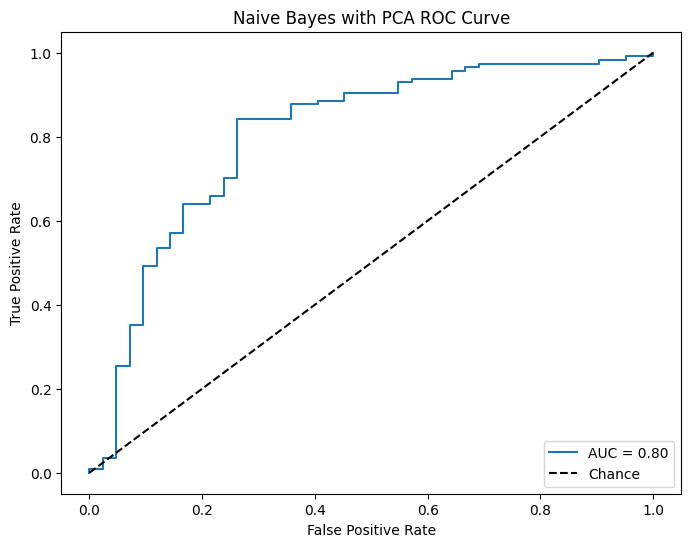

In [25]:
# Naive Bayes classification with PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_lda)

# Evaluate the model's performance
assess_model_performance(nb_clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Naive Bayes with PCA")